In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
import datetime
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/BadgerX Data"



Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1DebF_UxJ8HVlNU3YtYGSpTlwMstdY3sb/BadgerX Data


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import glob
from zipfile import ZipFile

narr_data = pd.DataFrame()
zipfiles = ["janmar.zip", "aprjun.zip", "julysept.zip", "octdec.zip"]

for zipfile in zipfiles:
    z = ZipFile("NARR_2010_2019_data/NARR_" + str(2011) + "/" + str(2011) + "_" + zipfile)
    for fl in z.infolist():
      narr_data = narr_data.append(pd.read_csv(z.open(fl.filename)))




In [4]:
narr_data.drop(columns=['Unnamed: 0'], inplace=True)
print(narr_data.columns)
narr_data['timestamp'] = narr_data['timestamp'].astype('string').str[0:8].astype(object)
narr_data

Index(['timestamp', 'latitude', 'longitude', 'temperature', 'humidity',
       'v_component', 'u_component', 'precipitation'],
      dtype='object')


,timestamp,latitude,longitude,temperature,humidity,v_component,u_component,precipitation
0,20110101,33.035931,-116.562660,281.597412,0.002380,0.220886,-0.810074,1.000000e-12
1,20110101,33.071072,-116.230690,278.925537,0.001690,0.220886,-0.810074,1.000000e-12
2,20110101,33.032425,-118.928047,284.488037,0.005730,2.080261,-3.200699,1.000000e-12
3,20110101,33.076347,-118.597565,284.456787,0.005160,2.095886,-3.200699,1.000000e-12
4,20110101,33.119057,-118.266624,284.363037,0.004680,1.783386,-3.622574,1.000000e-12
...,...,...,...,...,...,...,...,...
7699,20111231,42.683521,-125.922157,279.627991,0.005301,-4.497253,1.975174,1.000000e-12
7700,20111231,42.755314,-125.540146,279.627991,0.005201,-4.512878,1.959549,1.000001e-06
7701,20111231,42.825684,-125.157150,279.596741,0.005111,-3.653503,1.803299,1.000000e-12
7702,20111231,42.894619,-124.773178,279.502991,0.004911,-2.762878,1.897049,1.000000e-12


In [5]:
dates = []



for d in range(1, 366):
    day = datetime.datetime(2011, 1, 1) + datetime.timedelta(d - 1)
    dates.append(day.strftime("%Y%m%d"))

In [6]:
def regrid_narr_average(df, day):
    measurements = df[df["timestamp"].astype('string') == str(day)]
    grid = [[[[] for i in range(120)] for j in range(120)] for k in range(4)]
    for i in range(measurements.shape[0]):
        latidx = int((42 - measurements.iloc[i]["latitude"]) / 0.05)
        lonidx = int((measurements.iloc[i]["longitude"] + 124.5) / 0.05)
        if 119 >= latidx >= 0 and 0 <= lonidx <= 119:
          grid[0][latidx][lonidx].append(measurements.iloc[i]["humidity"])
          grid[1][latidx][lonidx].append(measurements.iloc[i]["precipitation"])
          grid[2][latidx][lonidx].append(measurements.iloc[i]["u_component"])
          grid[3][latidx][lonidx].append(measurements.iloc[i]["v_component"])




    final_grid = np.zeros((4,120, 120))
    count = 0
    for i in range(120):
        for j in range(120):
            for k in range(4):
                if len(grid[k][i][j]) != 0:
                    count += 1
                    final_grid[k, i, j] = sum(grid[k][i][j]) / len(grid[k][i][j])


    return final_grid.reshape(4*120*120)

In [7]:
def regrid_narr_maxmin(df, day, feature):
    measurements = df[(df["timestamp"].astype('string')) == str(day)]
    grid = [[[[] for i in range(120)] for j in range(120)] for k in range(len(feature))]
    for i in range(measurements.shape[0]):
        latidx = int((42 - measurements.iloc[i]["latitude"]) / 0.05)
        lonidx = int((measurements.iloc[i]["longitude"] + 124.5) / 0.05)
        for ft in range(len(feature)):
          if 119 >= latidx >= 0 and 0 <= lonidx <= 119:
            grid[ft][latidx][lonidx].append(measurements.iloc[i][feature[ft]])

    final_min_grid = np.zeros((len(feature),120, 120))
    final_max_grid = np.zeros((len(feature),120, 120))


    for i in range(120):
        for j in range(120):
            for k in range(len(feature)):
                if len(grid[k][i][j]) != 0:
                    final_min_grid[k, i, j] = min(grid[k][i][j])
                    final_max_grid[k, i, j] = max(grid[k][i][j])

    return final_min_grid.reshape(len(feature)*120*120), final_max_grid.reshape(len(feature)*120*120)

In [8]:
l = []
s2 = []
s3 = []
#change this when have full params
count = 0
for d in dates[:]:
  if count % 365 == 0:
    print(count/365)
  l.append(regrid_narr_average(narr_data, d));
  temp, temp2 = regrid_narr_maxmin(narr_data, d, ["temperature"])
  s2.append(temp)
  s3.append(temp2)
  count+=1

0.0


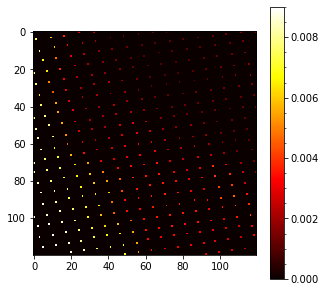

In [9]:
fig, (ax1) = plt.subplots(figsize=(5,5), ncols=1)
lolol = ax1.imshow(np.array(l[300][0:120*120]).reshape(120, 120), cmap='hot', interpolation='none')
cbar = fig.colorbar(lolol, ax=ax1)
cbar.minorticks_on()
plt.show()

In [10]:
import csv

with open("narr2011ave.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(l)
with open("narr2011s2.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(s2)

with open("narr2011s3.csv","w+") as my_csv:
  csvWriter = csv.writer(my_csv,delimiter=',')
  csvWriter.writerows(s3)

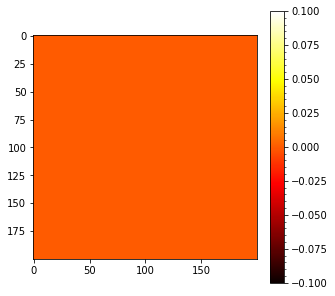

In [ ]:
fig, (ax1) = plt.subplots(figsize=(5,5), ncols=1)
lolol = ax1.imshow(np.array(l[260][200*200:400*200]).reshape(200, 200), cmap='hot', interpolation='none')
cbar = fig.colorbar(lolol, ax=ax1)
cbar.minorticks_on()
plt.show()

In [ ]:
from scipy.interpolate import interp2d
l2 = np.array(l[0][0:200*200]).reshape(200,200)
ix = np.where(l2 != 0)
f = interp2d(ix[0], ix[1], l2[ix].flatten(), kind='quintic')
mat2 = l2.copy()
mat2[l2==0] = f(range(200), range(200)).T[l2==0]


/usr/local/lib/python3.6/dist-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=5,5 nx,ny=38,36 m=963 fp=44.468559 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


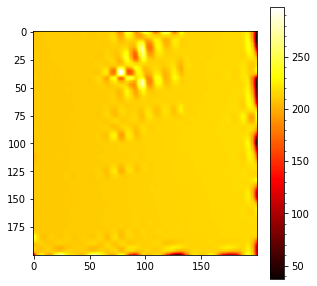

In [ ]:
fig, (ax1) = plt.subplots(figsize=(5,5), ncols=1)
lolol = ax1.imshow(mat2, cmap='hot', interpolation='none')
cbar = fig.colorbar(lolol, ax=ax1)
cbar.minorticks_on()
plt.show()


Good code no interpolation cool big up


In [ ]:
import csv
#change this once have features
sq = 120**2
l = np.array(l)
l[259][:] = l[258][:]
l[260][:] = l[261][:]
s2[259][:] = s2[258][:]
s2[260][:] = s2[261][:]
s3[259][:] = s3[258][:]
s3[260][:] = s3[261][:]

lh = l[:,0:sq].reshape(365*sq)
lw = l[:,sq:2*sq].reshape(365*sq)
s2t

lt = lt[lt != 0]
lh = lh[lh != 0]
lw = lw[lw != 0]

print(lt)
print(lh)
print(lw)



#should be (#, #/365) where the second value is an integer number. Otherwise we r ded and have to interpolate :(
print(lt.shape)
print(lh.shape)
print(lw.shape)


# with open("/content/drive/My Drive/BadgerX Data/UntransformedCSV/2019tempurature.csv","w+") as my_csv:
#     csvWriter = csv.writer(my_csv,delimiter=',')
#     csvWriter.writerows(lt) 

# with open("/content/drive/My Drive/BadgerX Data/UntransformedCSV/2019wind_speed.csv","w+") as my_csv:
#     csvWriter = csv.writer(my_csv,delimiter=',')
#     csvWriter.writerows(lw) 

# with open("/content/drive/My Drive/BadgerX Data/UntransformedCSV/2019humidity.csv","w+") as my_csv:
#     csvWriter = csv.writer(my_csv,delimiter=',')
#     csvWriter.writerows(lh)  

pd.DataFrame(lt).to_csv("2019temperature.csv", header=None, index=False)
pd.DataFrame(lh).to_csv("2019humidity.csv", header=None, index=False)
pd.DataFrame(lw).to_csv("2019wind_speed.csv", header=None, index=False)

[280.95918274 279.94551086 276.21504211 ... 216.3629818  217.33368492
 218.12470055]
[0.00311925 0.00220675 0.0027905  ... 0.00749848 0.00581098 0.00422598]
[ -3.40324974  -0.93449974  -0.66887474 ... -10.11991692  -4.90897942
  -2.62382317]
(351495,)
(351495,)
(351495,)




> Indented block



In [ ]:
from scipy.interpolate import interp2d
def interp(l2):
  ix = np.where(l2 != 0)
  f = interp2d(ix[0], ix[1], l2[ix].flatten(), kind='linear')
  mat2 = l2.copy()
  mat2[l2==0] = f(range(200), range(200)).T[l2==0]
  return mat2

In [ ]:
lt = l[:,0:200*200]
lh = l[:,200*200:400*200]
lw = l[:,400*200:-1]

for i in range(365):
  lh[i] = interp(lh[i,:])
  lw[i] = interp(lw[i,:])
  lt[i] = interp(lt[i,:])

lh = np.array(lh).reshape(365*200*200)
lw = np.array(lw).reshape(365*200*200)
lt = np.array(lt).reshape(365*200*200)

with open("/content/drive/My Drive/BadgerX Data/UntransformedCSV/2019tempuratureInterp.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(lt) 

with open("/content/drive/My Drive/BadgerX Data/UntransformedCSV/2019wind_speedInterp.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(lw) 

with open("/content/drive/My Drive/BadgerX Data/UntransformedCSV/2019humidityInterp.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(lh) 

IndexError: ignored